# Denoising Diffusion Probabilistic Models

A minimal DDPM implementation. See src/diffusion/models for the model classes.

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from diffusion.models.ddpm import DDPM

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
batch_size = 16
epochs = 5
T = 1000

In [ ]:
transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(), # [0,1]
        transforms.Lambda(lambda x: x * 2.0 - 1.0) #[-1,1]
    ])

mnist = datasets.MNIST(
    root="../data", train=True, download=True, transform=transform
)
dl = DataLoader(mnist, batch_size=batch_size, shuffle=True, num_workers=6)

In [5]:
ddpm = DDPM(img_channels=1, base_c=32, time_dim=128, T=T).to(device)

In [6]:
lr = 1e-5
optimizer = torch.optim.Adam(ddpm.parameters(), lr=lr)

In [ ]:
ddpm.train()
best_loss = float("inf")

for epoch in range(epochs):
    for i, (x, _) in enumerate(dl):
        x = x.to(device)  # (B,1,32,32) in [-1,1]

        optimizer.zero_grad()
        loss = ddpm(x)
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save(ddpm.state_dict(), "best_ddpm.pth")

        if i % 100 == 0:
            print(f"[Epoch {epoch} | Step {i}] Loss: {loss.item():.4f}")

[Epoch 0 | Step 0] Loss: 1.0225
[Epoch 0 | Step 100] Loss: 0.5008
[Epoch 0 | Step 200] Loss: 0.1877
[Epoch 0 | Step 300] Loss: 0.1764
[Epoch 0 | Step 400] Loss: 0.0594
[Epoch 0 | Step 500] Loss: 0.1422
[Epoch 0 | Step 600] Loss: 0.1063
[Epoch 0 | Step 700] Loss: 0.1036
[Epoch 0 | Step 800] Loss: 0.1061
[Epoch 0 | Step 900] Loss: 0.0639
[Epoch 0 | Step 1000] Loss: 0.0525
[Epoch 0 | Step 1100] Loss: 0.1061
[Epoch 0 | Step 1200] Loss: 0.1052
[Epoch 0 | Step 1300] Loss: 0.0418
[Epoch 0 | Step 1400] Loss: 0.1130
[Epoch 0 | Step 1500] Loss: 0.0842
[Epoch 0 | Step 1600] Loss: 0.0520
[Epoch 0 | Step 1700] Loss: 0.0470
[Epoch 0 | Step 1800] Loss: 0.0879
[Epoch 0 | Step 1900] Loss: 0.0771
[Epoch 0 | Step 2000] Loss: 0.0559
[Epoch 0 | Step 2100] Loss: 0.0411
[Epoch 0 | Step 2200] Loss: 0.0475
[Epoch 0 | Step 2300] Loss: 0.0261
[Epoch 0 | Step 2400] Loss: 0.0467
[Epoch 0 | Step 2500] Loss: 0.0438
[Epoch 0 | Step 2600] Loss: 0.0896
[Epoch 0 | Step 2700] Loss: 0.0474
[Epoch 0 | Step 2800] Loss: 0.03

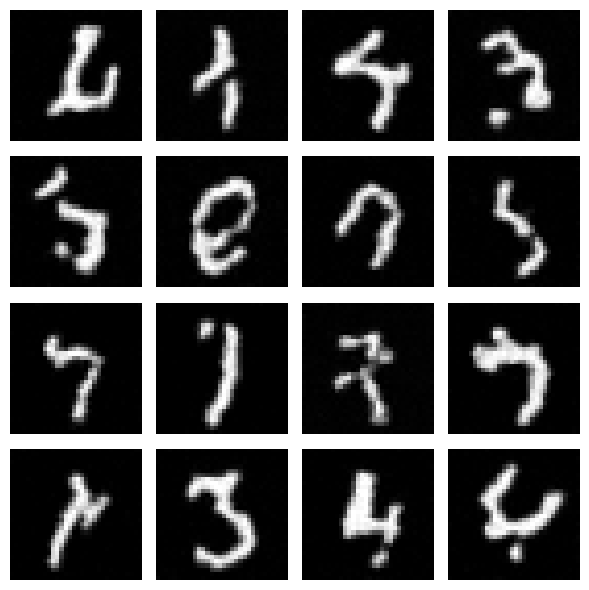

In [8]:
ddpm.eval()
with torch.no_grad():
    samples = ddpm.sample(n_samples=16, img_size=(1, 32, 32))  # [-1,1]


samples_vis = (samples + 1) / 2
samples_vis = samples_vis.clamp(0, 1).cpu()

fig, axes = plt.subplots(4, 4, figsize=(6, 6))

for ax, img in zip(axes.flatten(), samples_vis):
    ax.imshow(img[0], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
torch.save(ddpm.model.state_dict(), "last_unet.pth")
torch.save(ddpm.state_dict(), "last_ddpm.pth")

## Learning

After training the diffusion model for 5 epochs, the generated samples clearly show the structured of the digits with shapes characteristic of the MNIST dataset. Although the images still show some blur or deformation, the model consistently produces coherent strokes, curves, and global digit outlines, indicating that it successfully captured the data distribution. This confirms that the U-Net architecture, time-step conditioning, and denoising objective were effectively learned during training.

## Future Work

We can improve the model exploring the model’s generative quality. A cosine noise schedule and exponential moving average (EMA) of parameters could increase stability and sharpen the generated digits. Incorporating self-attention layers may allow the model to better capture long-range dependencies, while expanding the U-Net’s capacity could help to be more detailed and diverse samples. Finally, training on more complex datasets such as CIFAR-10 or CelebA would allow the model architecture to scale toward more challenging, real world generative tasks.